In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd
from scipy.signal import butter, filtfilt

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
audio_files_train_normal = glob('/content/drive/MyDrive/Sound Data Split/Train/Normal/*.wav')

In [3]:
# Play audio file
ipd.Audio(audio_files_train_normal[10])

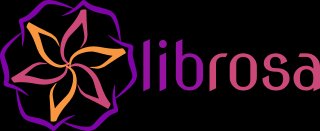



In [11]:
audio,sr =librosa.load(audio_files_train_normal[10])

In [ ]:
y, sr = librosa.load('/content/drive/MyDrive/Sound Data Split/Train/Anomaly/41267024_0.3_0_p1_2359.wav')
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

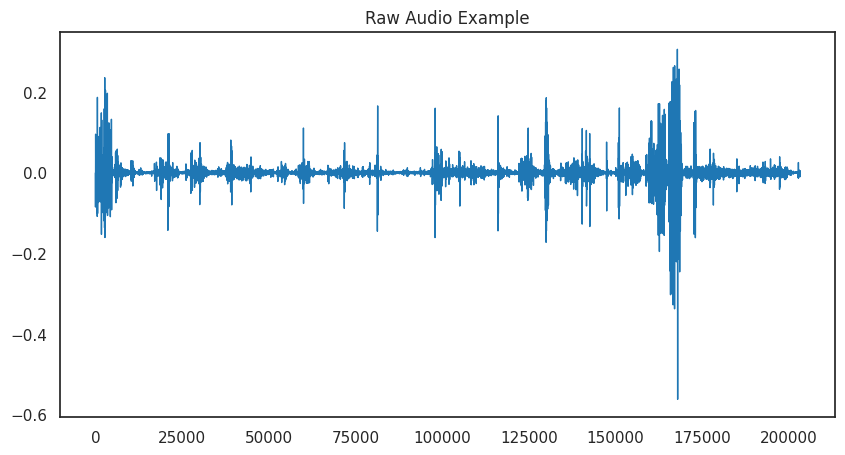

In [15]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

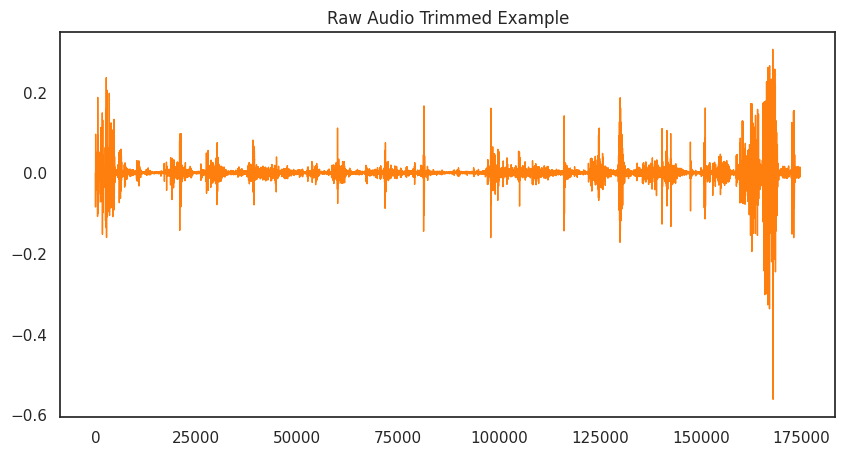

In [16]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=15)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

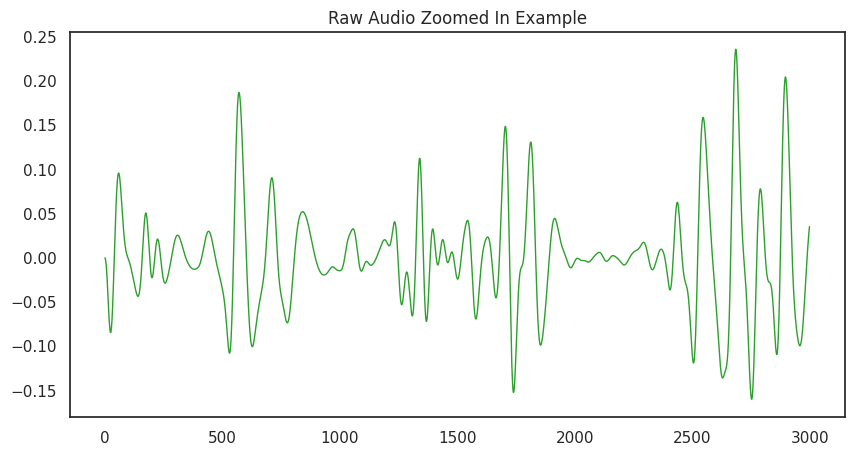

In [17]:
pd.Series(y[0:3000]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

In [18]:
D = np.abs(librosa.stft(y))
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 397)

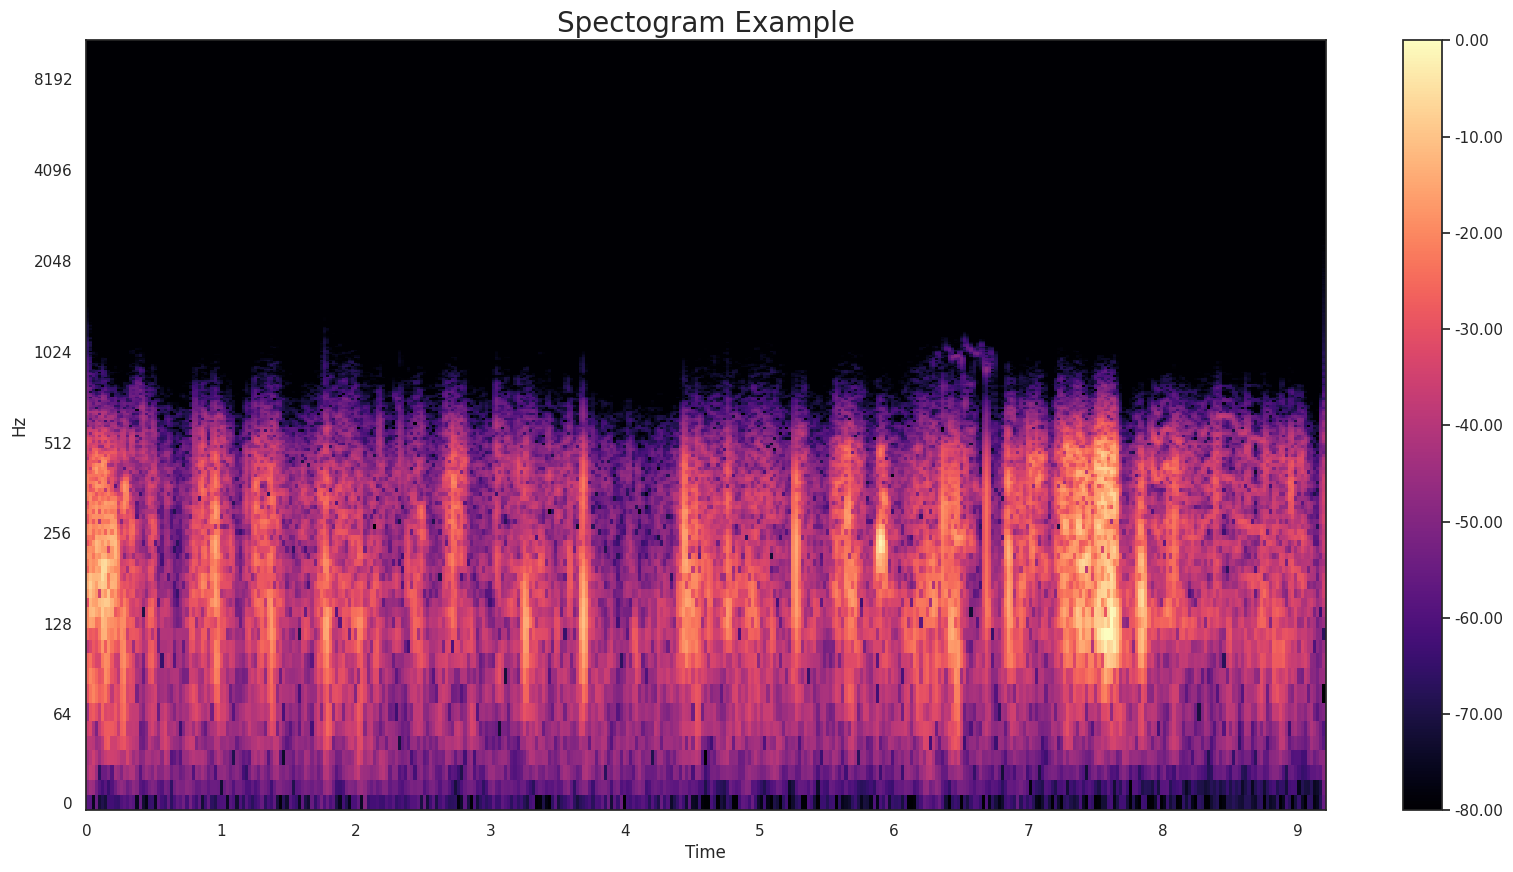

In [19]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(20, 10))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [20]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

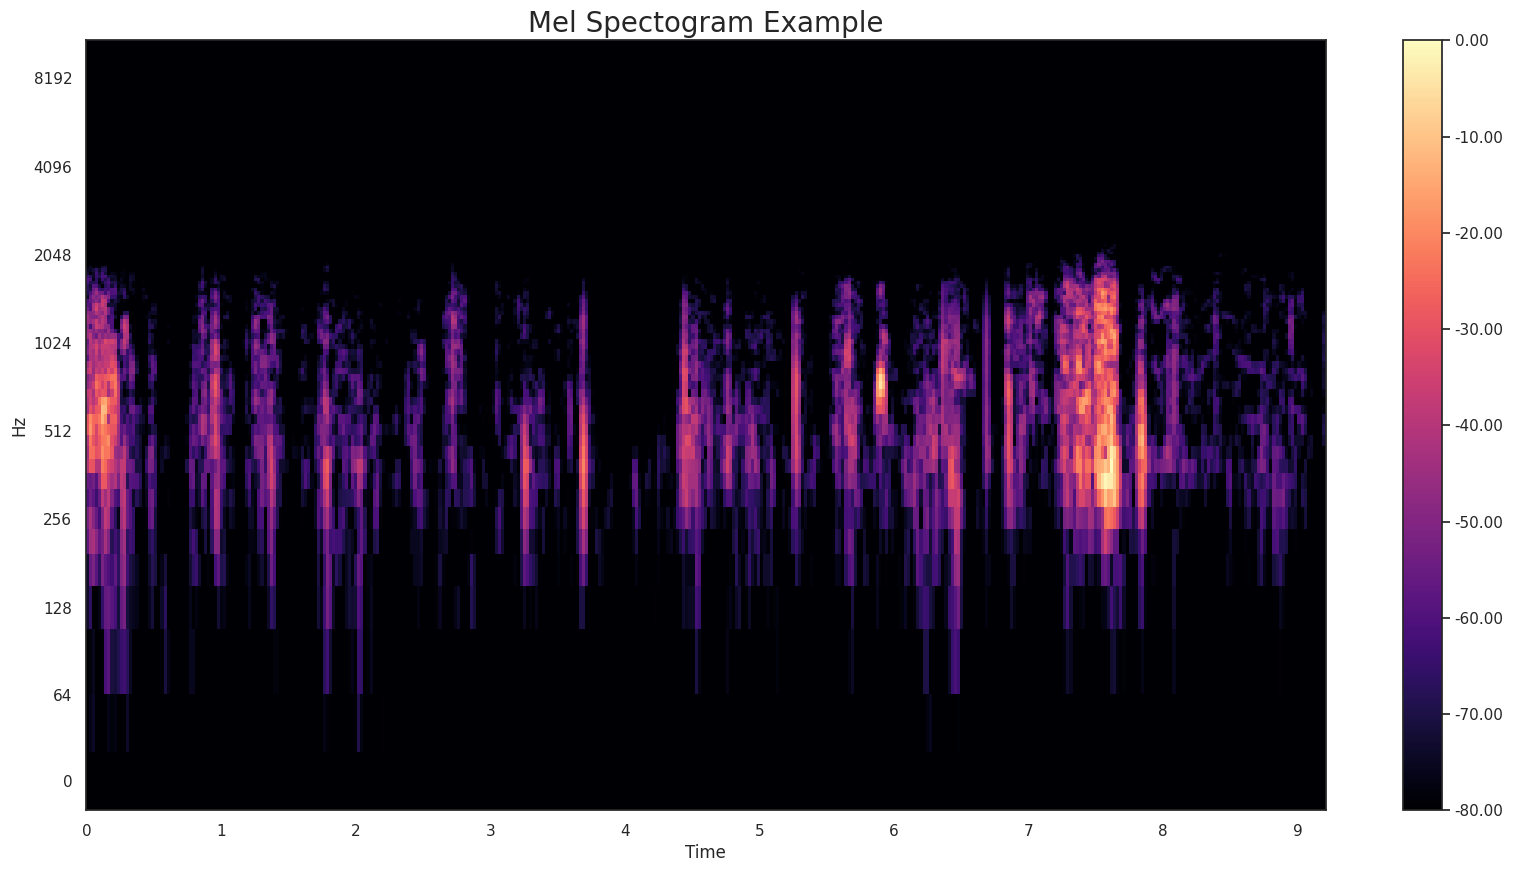

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

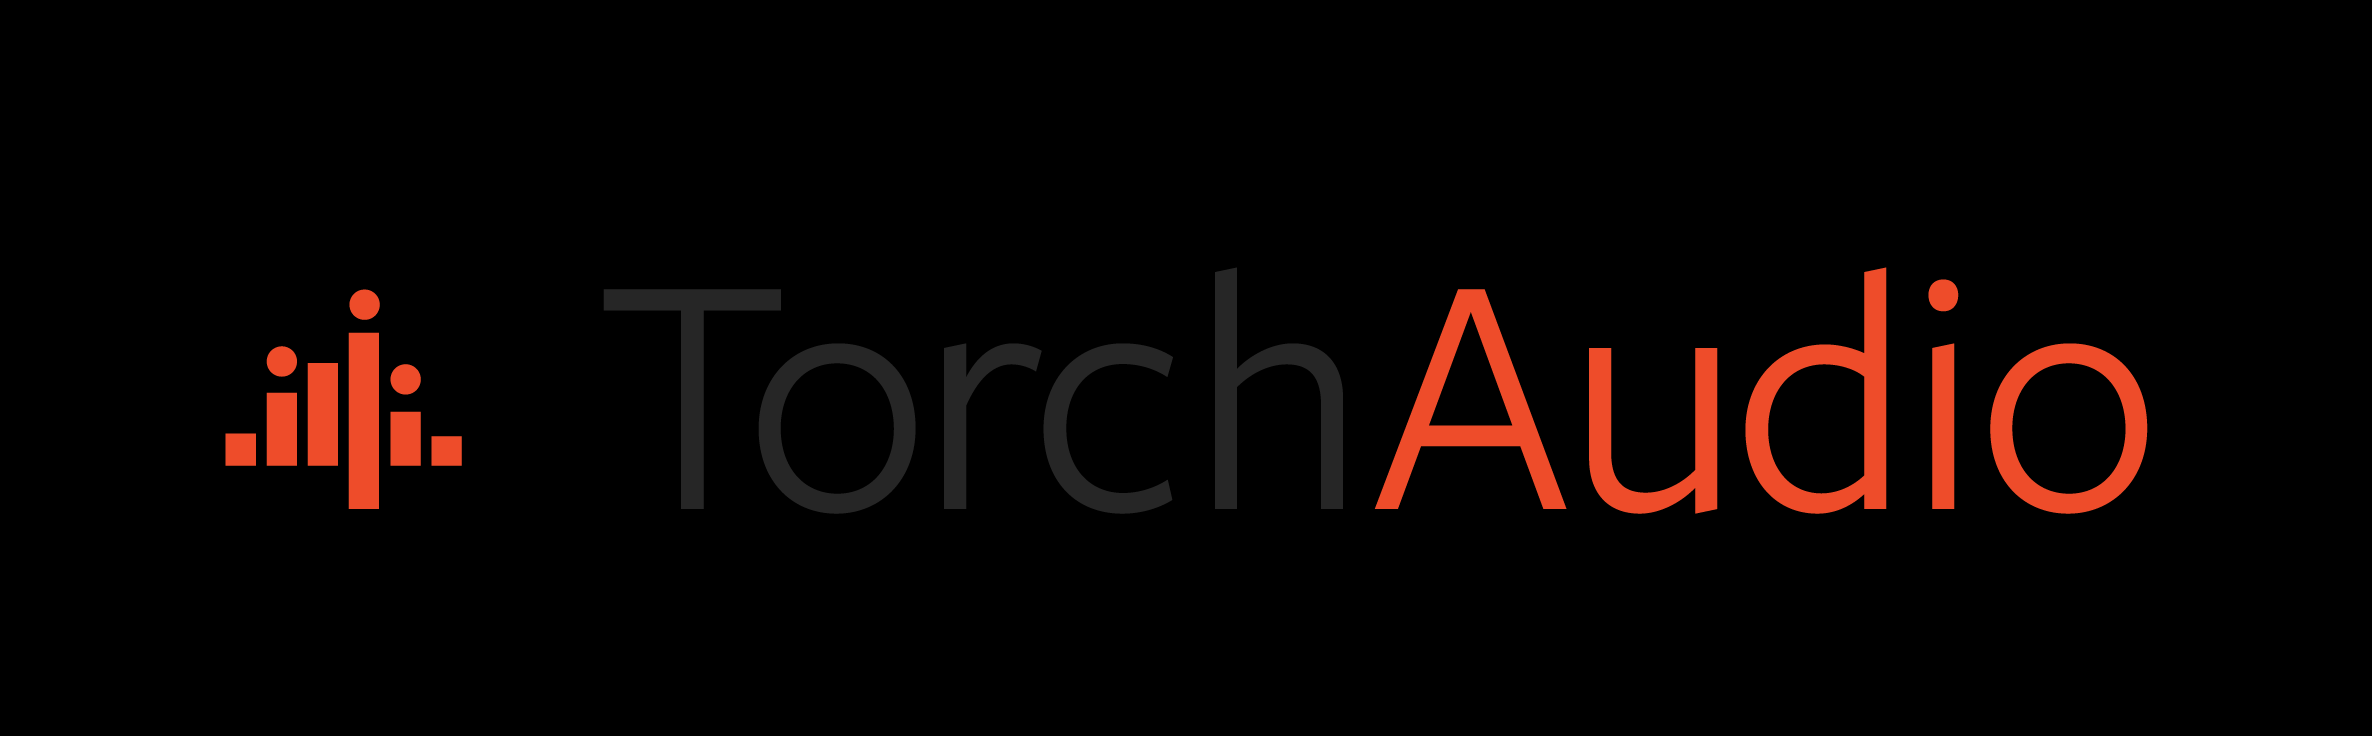

# **Save spectograms as images 224x224x3**

In [7]:
import numpy as np
import os
from PIL import Image
import cv2
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import torch
import torchaudio
import torchaudio.transforms as T
from torchaudio.transforms import Resample

In [8]:
def filter_fn(waveform):

    sr = 8000
    #denoising
    # Define the filter parameters
    lowcut = 50 # Hz
    highcut = 2500 # Hz
    order = 5 # 5th order Butterworth filter
    # Normalize the cut-off frequencies with respect to the Nyquist frequency
    nyquist_freq = 0.5 * sr
    lowcut_normalized = lowcut / nyquist_freq
    highcut_normalized = highcut / nyquist_freq
    # Create the Butterworth filter coefficients using the `butter` function from SciPy
    b, a = butter(order, [lowcut_normalized, highcut_normalized], btype='band')
    # Transpose waveform from (batch_size, num_channels, samples) to (samples, num_channels)
    waveform = waveform.transpose(1, 0).contiguous()

    # Apply filter using filtfilt from scipy.signal
    waveform = waveform.numpy()
    waveform = filtfilt(b, a, waveform, axis=0)
    waveform = torch.from_numpy(waveform.copy())
    # Transpose back to original shape (num_channels, samples, batch_size)
    waveform = waveform.transpose(1, 0).contiguous()
    return waveform

In [9]:
# Define a custom function to load and preprocess the audio files
def load_audio(audio_path,save_dir,filename):
    # Load the audio file using a library such as librosa

    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate!=8000:
      print('WARNING SR!')

    n_fft = 400
    power = 2
    spectrogram = T.Spectrogram(
            n_fft=n_fft,
            win_length = None,
            hop_length = None,
            power=power
        )



    wavefrom_filtered = filter_fn(waveform)
    spec = torch.abs(spectrogram(wavefrom_filtered))
    spec = librosa.power_to_db(spec)
    spec = spec[0, :, :]

    # normalize the spectrogram values to the range [0, 255]
    spectrogram_norm = (spec - np.min(spec)) / (np.max(spec) - np.min(spec)) * 255
    spectrogram_norm = spectrogram_norm.astype(np.uint8)

    # create a PIL Image object from the spectrogram array
    img = Image.fromarray(spectrogram_norm)
    # save the image to the directory
    img.save(os.path.join(save_dir, filename))

In [10]:
load_audio('/content/drive/MyDrive/Sound Data Split/Train/Normal/40138127_14.7_0_p3_139.wav','','test.png')



*   Train



In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Train/Normal/"
destination_folder = "/content/drive/MyDrive/Image Data Split/Train/Normal/"
cpt = 0
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio(source,destination_folder , file_name)
print(cpt)

1303


In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Train/Anomaly/"
destination_folder = "/content/drive/MyDrive/Image Data Split/Train/Anomaly/"
cpt = 0
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio(source,destination_folder , file_name)
print(cpt)

469


In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Train/Poor Quality/"
destination_folder = "/content/drive/MyDrive/Image Data Split/Train/Poor Quality/"
cpt = 0
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio(source,destination_folder , file_name)
print(cpt)

177




*    Test intra


In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Test intra/Normal/"
destination_folder = "/content/drive/MyDrive/Image Data Split/Test intra/Normal/"
cpt = 0
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio(source,destination_folder , file_name)
print(cpt)

241


In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Test intra/Anomaly/"
destination_folder = "/content/drive/MyDrive/Image Data Split/Test intra/Anomaly/"
cpt = 0
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio(source,destination_folder , file_name)
print(cpt)

136


In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Test intra/Poor Quality/"
destination_folder = "/content/drive/MyDrive/Image Data Split/Test intra/Poor Quality/"
cpt = 0
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio(source,destination_folder , file_name)
print(cpt)

2




*   Test inter



In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Test inter/Normal/"
destination_folder = "/content/drive/MyDrive/Image Data Split/Test inter/Normal/"
cpt = 0
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio(source,destination_folder , file_name)
print(cpt)

241


In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Test inter/Anomaly/"
destination_folder = "/content/drive/MyDrive/Image Data Split/Test inter/Anomaly/"
cpt = 0
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio(source,destination_folder , file_name)
print(cpt)

106


In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Test inter/Poor Quality/"
destination_folder = "/content/drive/MyDrive/Image Data Split/Test inter/Poor Quality/"
cpt = 0
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio(source,destination_folder , file_name)
print(cpt)

8


In [ ]:
main_split_dir ='/content/drive/MyDrive/Image Data Split/'
print(os.listdir(main_split_dir))
train_dir ='/content/drive/MyDrive/Image Data Split/Train/'
print(os.listdir(train_dir))
test_intra_dir ='/content/drive/MyDrive/Image Data Split/Test intra/'
print(os.listdir(test_intra_dir))
test_inter_dir ='/content/drive/MyDrive/Image Data Split/Test inter/'
print(os.listdir(test_inter_dir))

['Train', 'Test intra', 'Test inter']
['Anomaly', 'Normal', 'Poor Quality']
['Normal', 'Anomaly', 'Poor Quality']
['Normal', 'Anomaly', 'Poor Quality']


In [ ]:
from prettytable import PrettyTable

In [ ]:
#train
num_train_normal= len(os.listdir(train_dir+'Normal/'))
num_train_anomaly = len(os.listdir(train_dir+'Anomaly/'))
num_train_poor = len(os.listdir(train_dir+'Poor Quality/'))
Tot_train =  num_train_poor + num_train_anomaly + num_train_normal

#test intra
num_test_intra_normal = len(os.listdir(test_intra_dir+'Normal/'))
num_test_intra_anomaly = len(os.listdir(test_intra_dir+'Anomaly/'))
num_test_intra_poor = len(os.listdir(test_intra_dir+'Poor Quality/'))
Tot_test_intra =  num_test_intra_normal + num_test_intra_anomaly + num_test_intra_poor

#test inter
num_test_inter_normal = len(os.listdir(test_inter_dir+'Normal/'))
num_test_inter_anomaly = len(os.listdir(test_inter_dir+'Anomaly/'))
num_test_inter_poor = len(os.listdir(test_inter_dir+'Poor Quality/'))
Tot_test_inter =  num_test_inter_normal + num_test_inter_anomaly + num_test_inter_poor

#table stat general
t = PrettyTable(['Class','Train','Test intra','Test inter'])
t.add_row(['Normal',num_train_normal,num_test_intra_normal,num_test_inter_normal])
t.add_row(['Anomaly',num_train_anomaly,num_test_intra_anomaly,num_test_inter_anomaly])
t.add_row(['Poor Quality',num_train_poor,num_test_intra_poor,num_test_inter_poor])
t.add_row(['Total',Tot_train,Tot_test_intra,Tot_test_inter])
print(t)

+--------------+-------+------------+------------+
|    Class     | Train | Test intra | Test inter |
+--------------+-------+------------+------------+
|    Normal    |  1303 |    241     |    241     |
|   Anomaly    |  469  |    136     |    106     |
| Poor Quality |  177  |     2      |     8      |
|    Total     |  1949 |    379     |    355     |
+--------------+-------+------------+------------+


# **Audio Augmentation (Tests)**

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as T
from torchaudio.transforms import Resample

sr = 8000

print(torch.__version__)
print(torchaudio.__version__)

2.0.0+cu118
2.0.1+cu118


In [ ]:
#plot spectograms
def plot_spectrogram(spec, title=None, ylabel="Frequency (Hz)", aspect="auto", xmax=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title(title or "Spectrogram (db)")
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time (s)")
    img = librosa.display.specshow(librosa.power_to_db(spec),
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show(block=False)



*   5th butterworth band pass filter between 50HZ and 2500hz



In [ ]:
from scipy.signal import butter, filtfilt

#denoising
# Define the filter parameters
lowcut = 50 # Hz
highcut = 2500 # Hz
order = 5 # 5th order Butterworth filter
# Normalize the cut-off frequencies with respect to the Nyquist frequency
nyquist_freq = 0.5 * sr
lowcut_normalized = lowcut / nyquist_freq
highcut_normalized = highcut / nyquist_freq
# Create the Butterworth filter coefficients using the `butter` function from SciPy
b, a = butter(order, [lowcut_normalized, highcut_normalized], btype='band')

# Convert the coefficients to PyTorch tensors
#b = torch.tensor(b, dtype=torch.float32)
#a = torch.tensor(a, dtype=torch.float32)

# Create a filter function using torchaudio's lfilter function
def filter_fn(waveform):
    # Transpose waveform from (batch_size, num_channels, samples) to (samples, num_channels)
    waveform = waveform.transpose(1, 0).contiguous()

    # Apply filter using filtfilt from scipy.signal
    waveform = waveform.numpy()
    waveform = filtfilt(b, a, waveform, axis=0)
    waveform = torch.from_numpy(waveform.copy())
    # Transpose back to original shape (num_channels, samples, batch_size)
    waveform = waveform.transpose(1, 0).contiguous()
    return waveform

8000


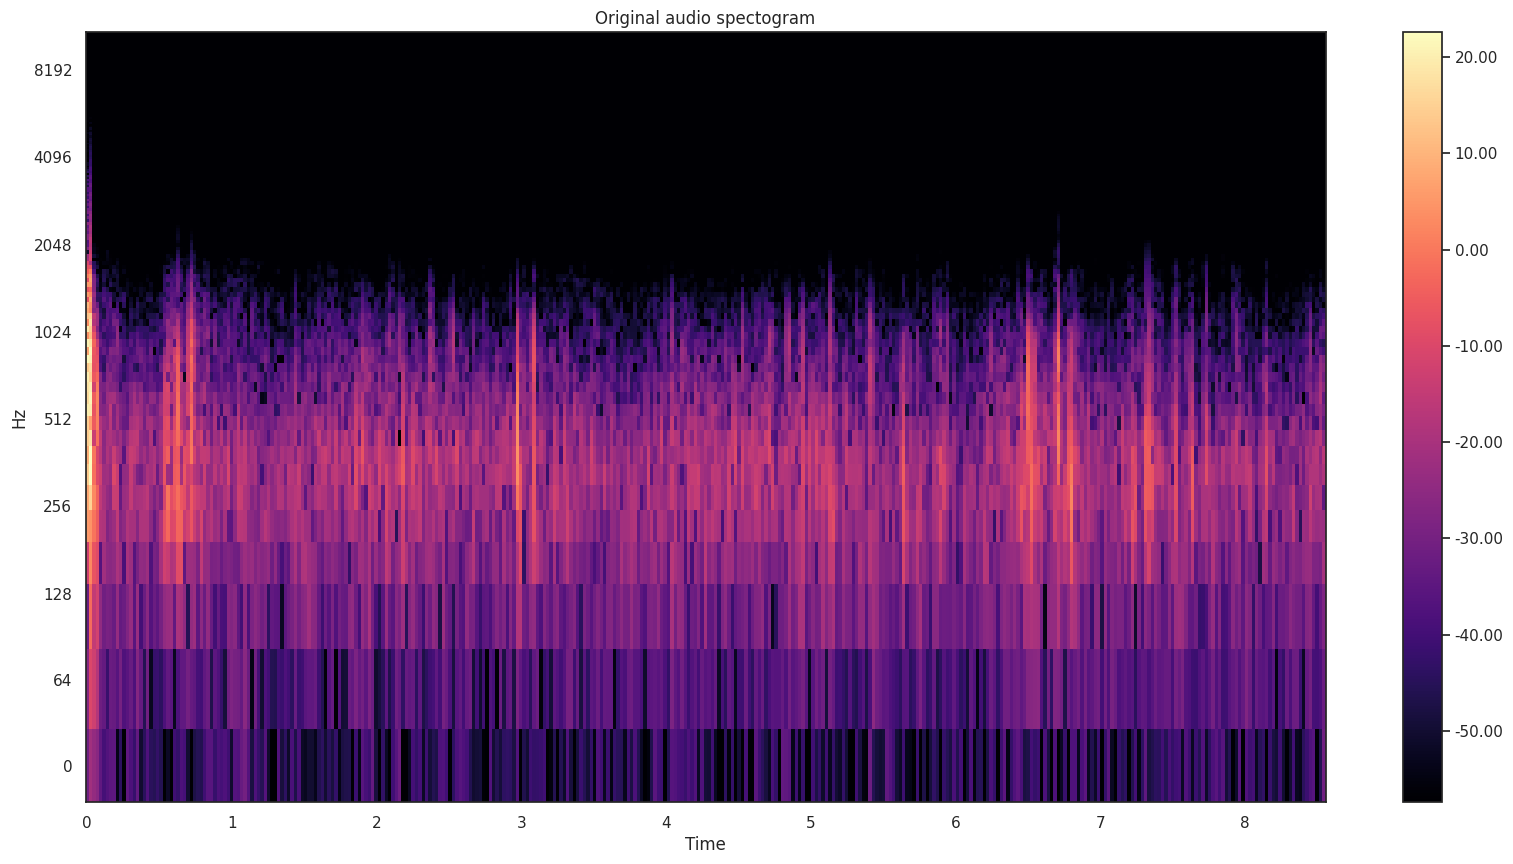

torch.Size([201, 369])


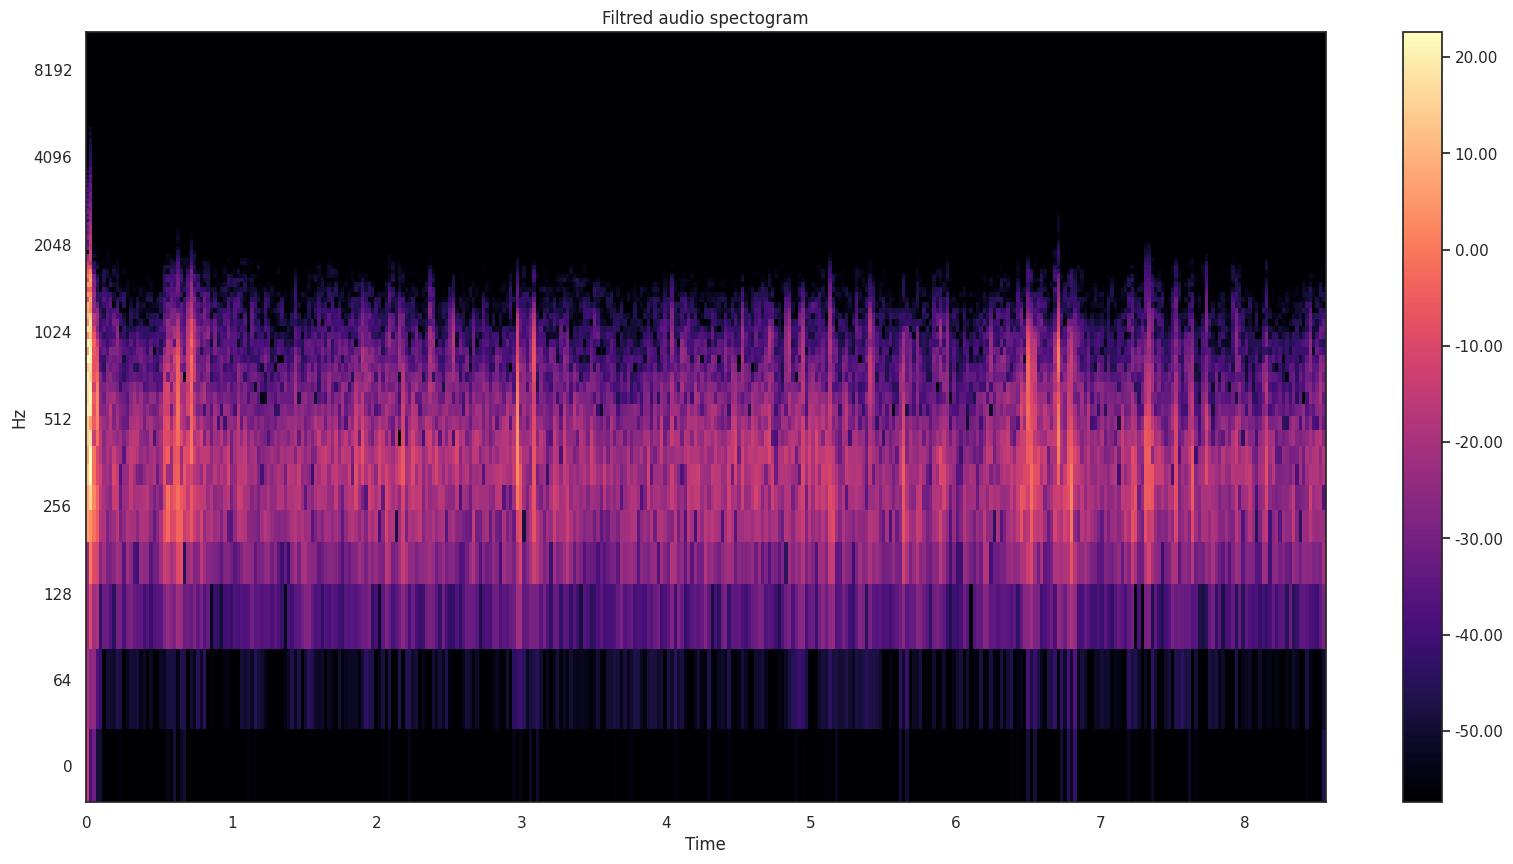

In [ ]:
#test
audio_path = '/content/drive/MyDrive/Sound Data Split/Train/Normal/40138127_14.7_0_p3_139.wav'
n_fft = 400
power = 2
spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length = None,
        hop_length = None,
        power=power
    )
#original audio
waveform, sample_rate = torchaudio.load(audio_path)
print(sample_rate)

spec = spectrogram(waveform)
plot_spectrogram(torch.abs(spec[0]), 'Original audio spectogram')

#filtered audio

wavefrom_filtered = filter_fn(waveform)
spec = spectrogram(wavefrom_filtered)
print(spec[0].shape)
plot_spectrogram(torch.abs(spec[0]), 'Filtred audio spectogram')



*   Librosa (init method)



(1025, 145)


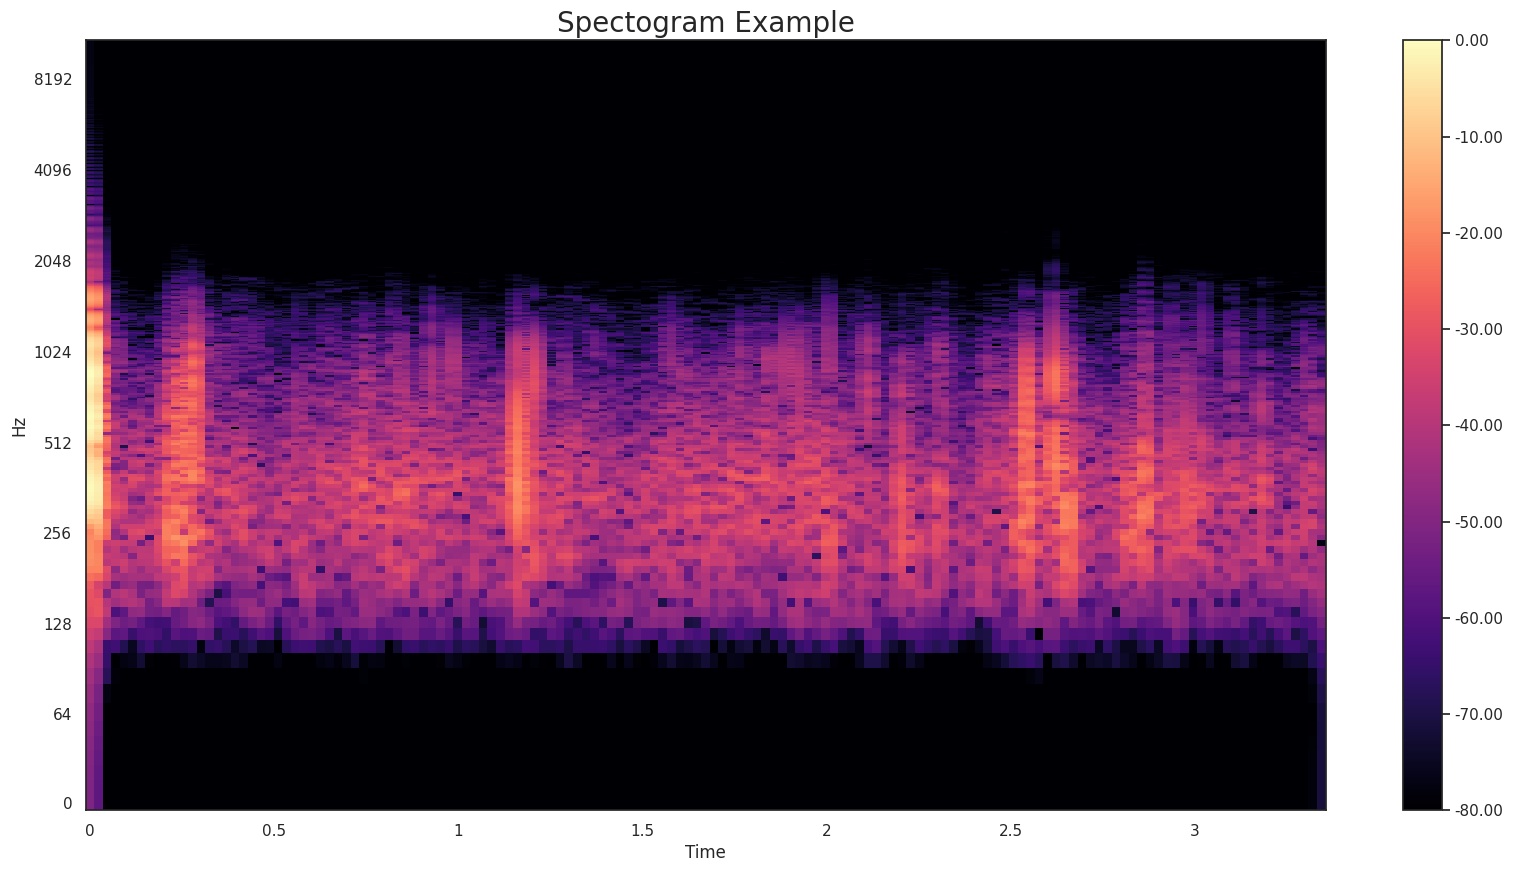

In [ ]:
# Load the audio file using a library such as librosa
audio_data, sample_rate = librosa.load(audio_path,mono=True,sr=8000)
#denoising
# Define the filter parameters
lowcut = 50 # Hz
highcut = 2500 # Hz
order = 5 # 5th order Butterworth filter
# Normalize the cut-off frequencies with respect to the Nyquist frequency
sr=8000
nyquist_freq = 0.5 * sr
lowcut_normalized = lowcut / nyquist_freq
highcut_normalized = highcut / nyquist_freq
# Create the Butterworth filter coefficients using the `butter` function from SciPy
b, a = butter(order, [lowcut_normalized, highcut_normalized], btype='band')
# Apply the filter to the signal using the `filtfilt` function from SciPy
filtered_signal = filtfilt(b, a, audio_data)

D = np.abs(librosa.stft(filtered_signal))
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
print(S_db.shape)
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(20, 10))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()



*   Time Stretch



torch.Size([1, 201, 462])


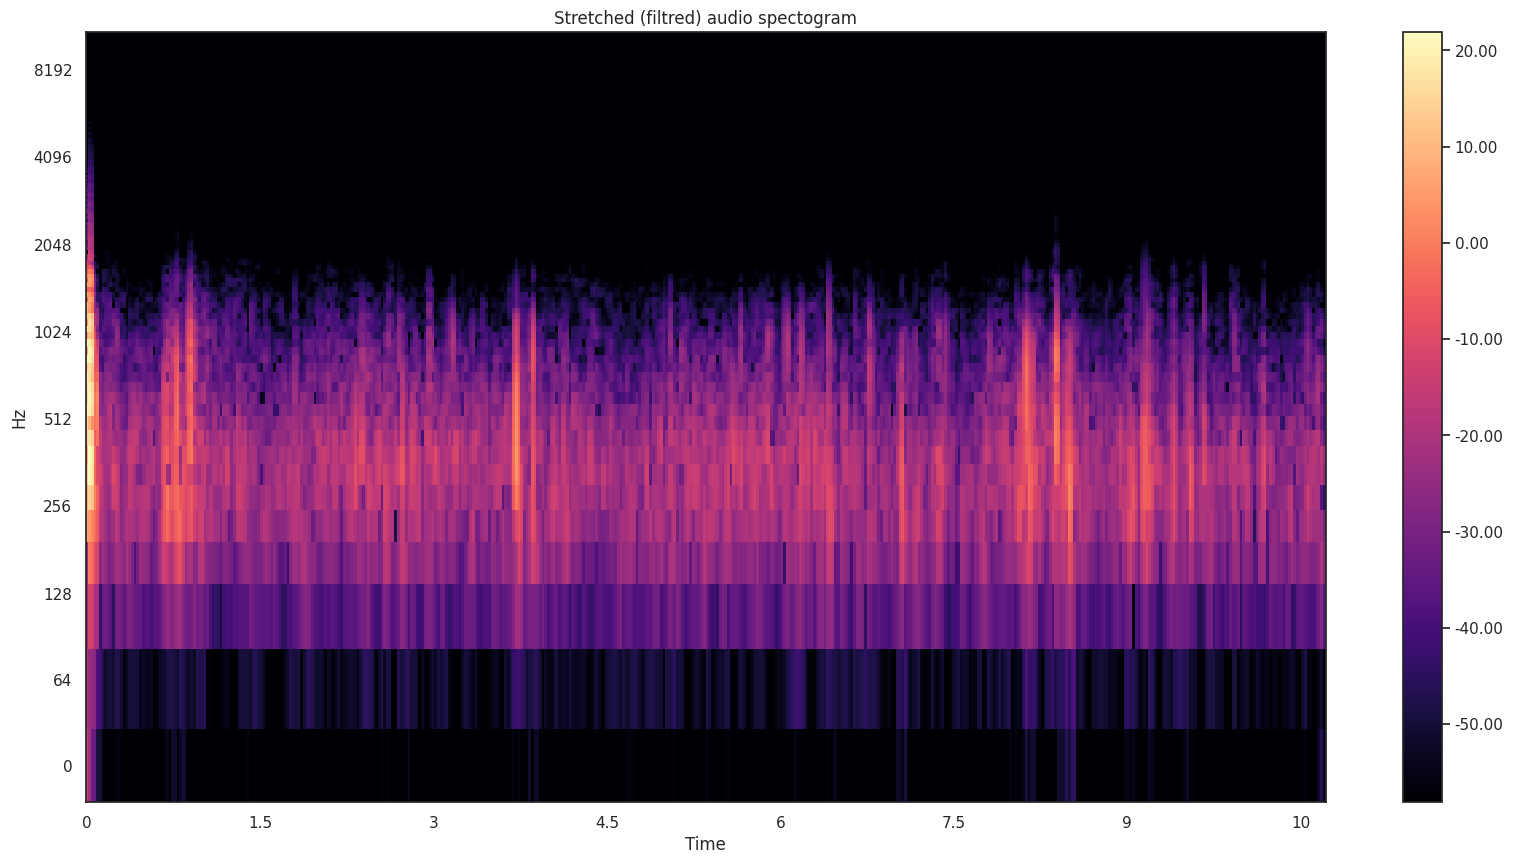

In [ ]:
stretch = T.TimeStretch()
rate = 0.8
spec_st = stretch(spec.clone(), rate)
print(spec_st.shape)
plot_spectrogram(torch.abs(spec_st[0]),'Stretched (filtred) audio spectogram')



*   Time Masking



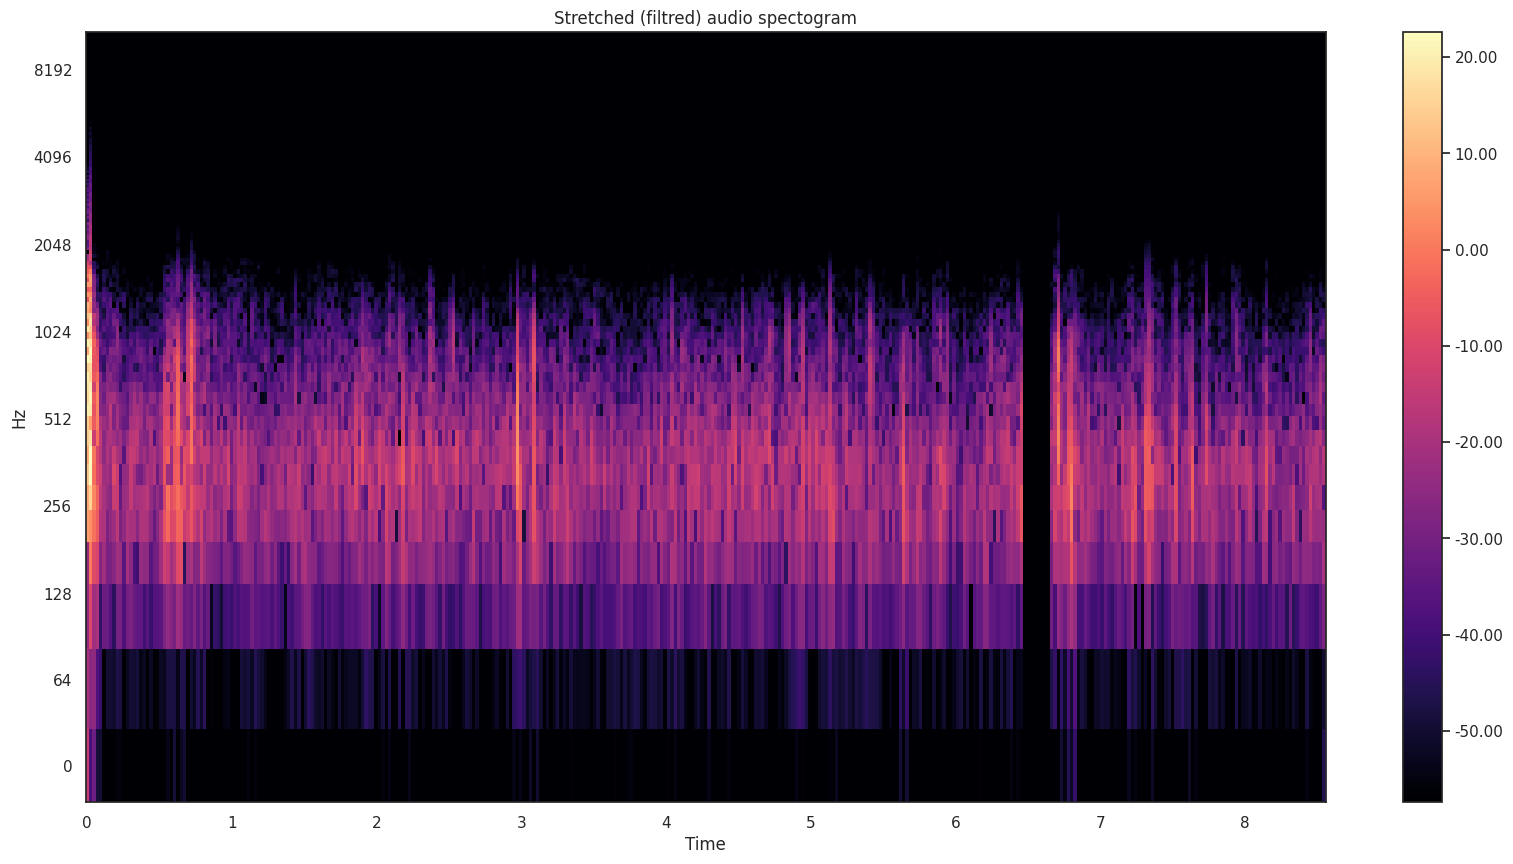

In [ ]:
T_masking = T.TimeMasking(time_mask_param=10)
spec_msk_t = T_masking(spec.clone())
plot_spectrogram(torch.abs(spec_msk_t[0]),'Stretched (filtred) audio spectogram')



*   Custom Time Masking



In [ ]:
import random
def custom_time_masking(spec_in, min_mask_width=5, max_mask_width=100):
    # spec: input spectrogram, shape (1,num_freqs, num_time_steps)
    # min_mask_width: minimum number of time bands to mask (default=0)
    # max_mask_width: maximum number of time bands to mask (default=80)

    freq_mask_width = random.randint(min_mask_width, max_mask_width)
    if freq_mask_width == 0:
        return spec_in

    # Choose a random starting point
    freq_start = random.randint(0, spec_in.shape[2])
    if freq_start == spec_in.shape[2] :
       freq_start = freq_start - freq_mask_width

    # Apply the frequency mask

    spec_in[:,:,freq_start:freq_start+freq_mask_width]  = 0.0

    return spec_in


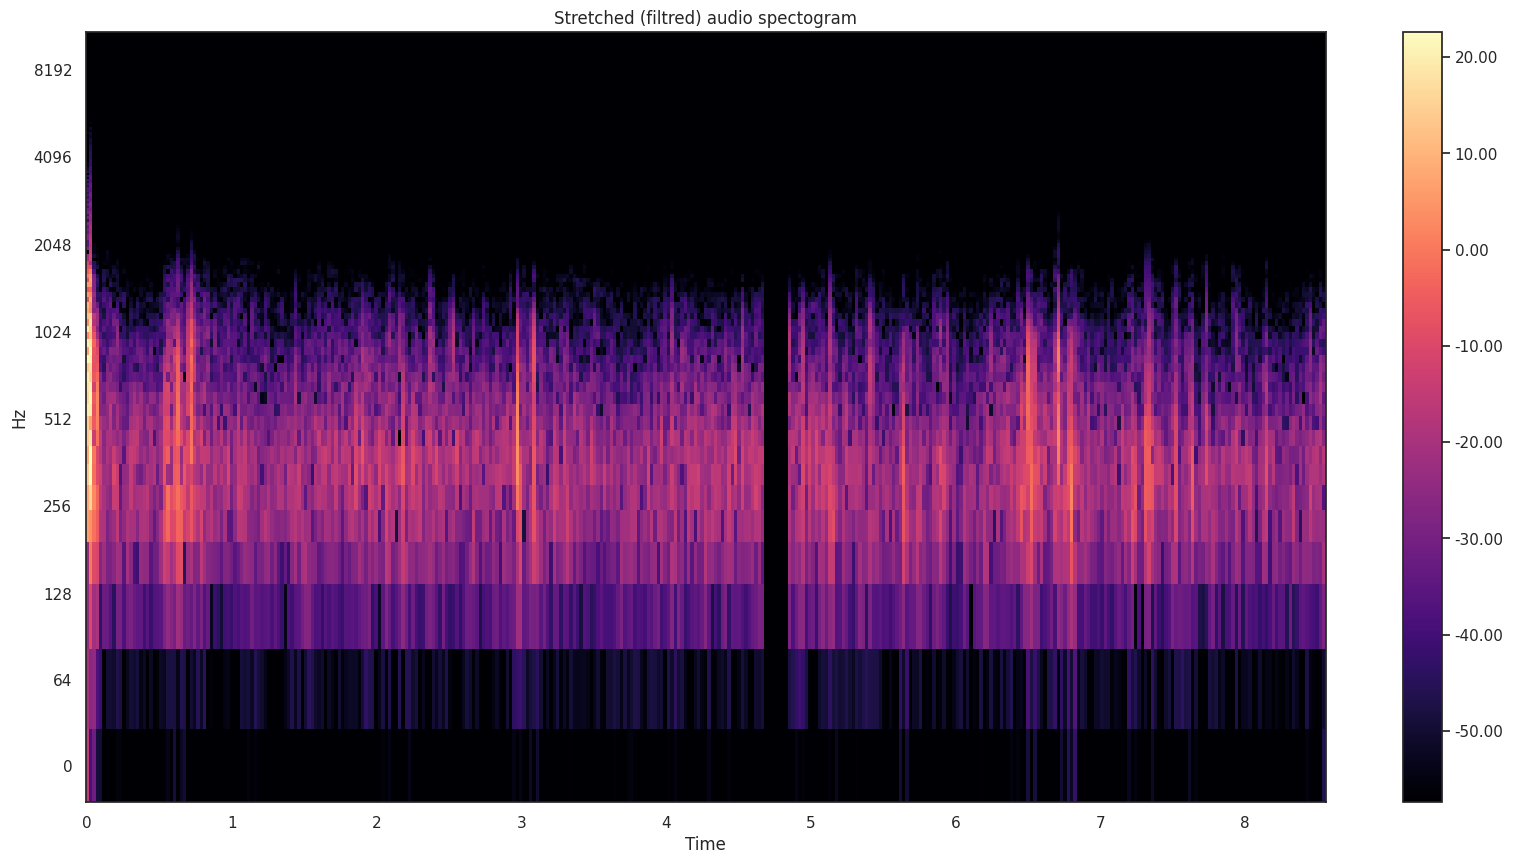

In [ ]:
spec_msk_t = custom_time_masking(spec.clone(), 5, 8)
plot_spectrogram(torch.abs(spec_msk_t[0]),'Stretched (filtred) audio spectogram')



*   Frequency Masking



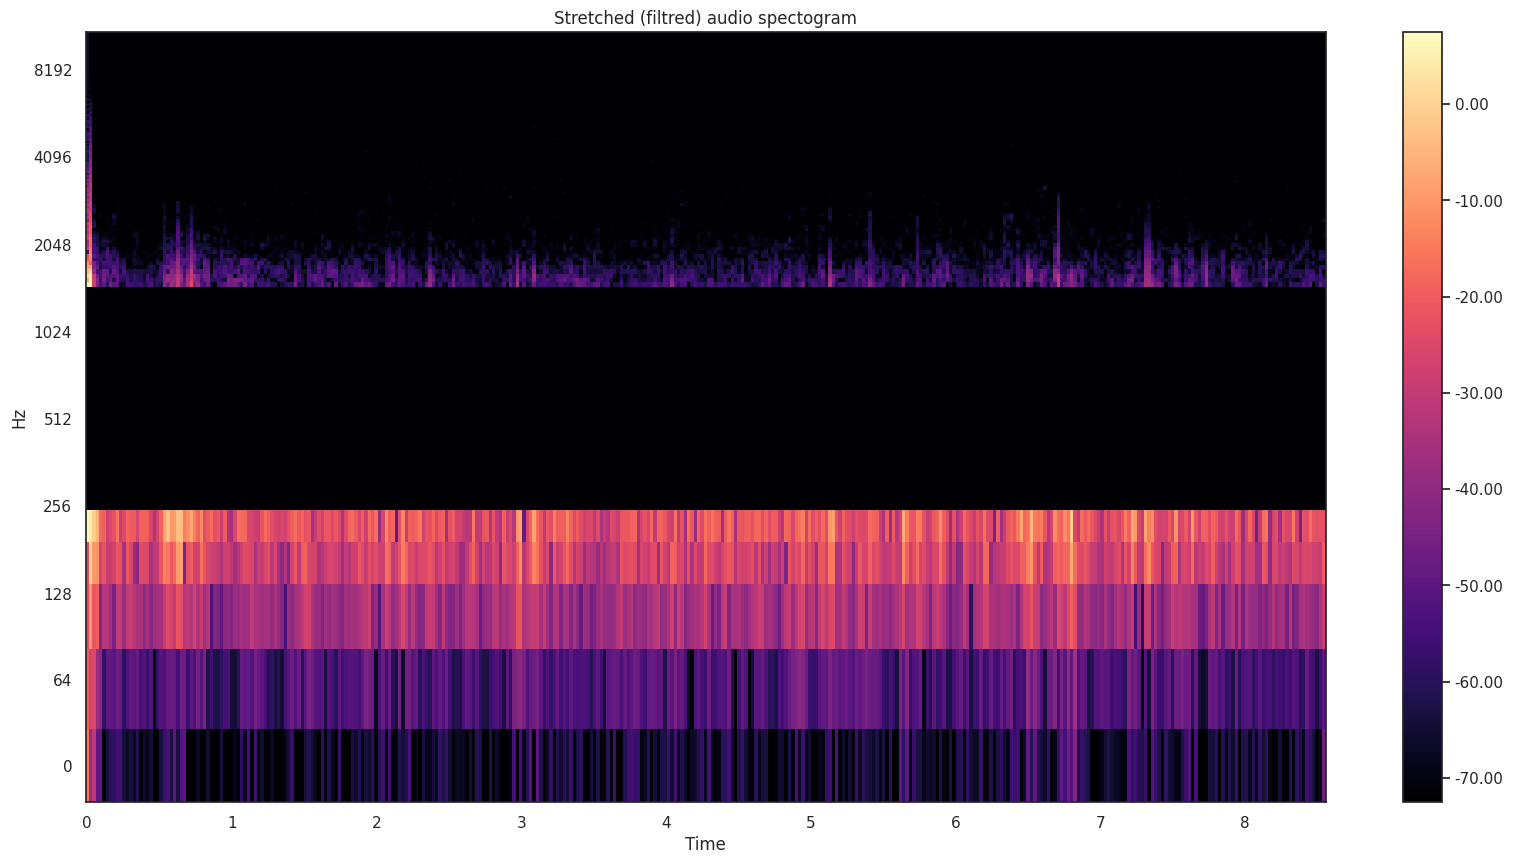

In [ ]:
F_masking = T.FrequencyMasking(freq_mask_param=80)
spec_msk_f = F_masking(spec.clone())
plot_spectrogram(torch.abs(spec_msk_f[0]),'Stretched (filtred) audio spectogram')



*   Custom Frequency Masking



In [ ]:
import random
def custom_freq_masking(spec_in, min_mask_width=0, max_mask_width=80):
    # spec: input spectrogram, shape (1,num_freqs, num_time_steps)
    # min_mask_width: minimum number of frequency bands to mask (default=0)
    # max_mask_width: maximum number of frequency bands to mask (default=80)

    freq_mask_width = random.randint(min_mask_width, max_mask_width)
    if freq_mask_width == 0:
        return spec_in

    # Choose a random starting point
    freq_start = random.randint(10, 20)

    # Apply the frequency mask

    spec_in[:,freq_start:freq_start+freq_mask_width, :]  = 0.0

    return spec_in


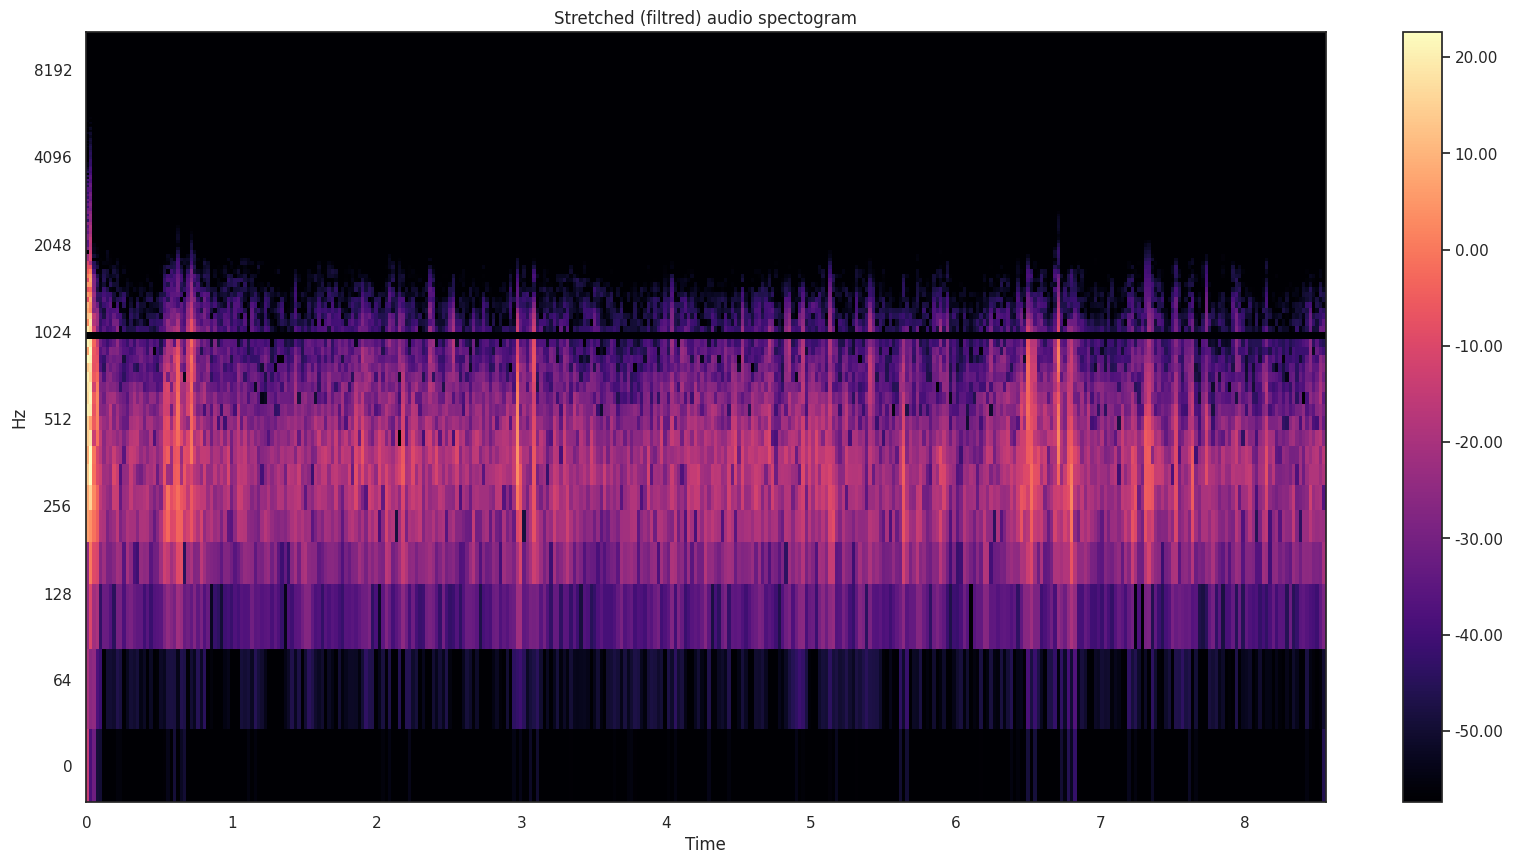

In [ ]:
spec_msk_f = custom_freq_masking(spec.clone(), 1, 2)
plot_spectrogram(torch.abs(spec_msk_f[0]),'Stretched (filtred) audio spectogram')

# **Audio Augmentation Saving**

In [ ]:
# Define a custom function to load and preprocess the audio files
def load_audio_augmented(audio_path,save_dir,filename,Aug_func_ind):
    '''
    Augmentation Parameters for policies
    -------------------------
    Policy | TS  | FM  | TM |
    -------------------------

    TS  : Time Stretching
    FM  : Frequency Masking
    TM  : Time Masking

    '''
    # Load the audio file using a library such as librosa
    waveform, sample_rate = torchaudio.load(audio_path)

    if sample_rate!=8000:
      print('WARNING SR!')

    audio_path
    n_fft = 400
    power = 2
    spectrogram = T.Spectrogram(
            n_fft=n_fft,
            win_length = None,
            hop_length = None,
            power=power
        )

    #denoising
    # Define the filter parameters
    lowcut = 50 # Hz
    highcut = 2500 # Hz
    order = 5 # 5th order Butterworth filter
    # Normalize the cut-off frequencies with respect to the Nyquist frequency
    nyquist_freq = 0.5 * sr
    lowcut_normalized = lowcut / nyquist_freq
    highcut_normalized = highcut / nyquist_freq
    # Create the Butterworth filter coefficients using the `butter` function from SciPy
    b, a = butter(order, [lowcut_normalized, highcut_normalized], btype='band')

    wavefrom_filtered = filter_fn(waveform)
    spec = spectrogram(wavefrom_filtered)

    if Aug_func_ind == 'TS':
          stretch = T.TimeStretch()
          rate = 0.8
          spec = stretch(spec.clone(), rate)
    elif  Aug_func_ind == 'FM':
          spec = custom_freq_masking(spec.clone(), 1, 2)
    elif Aug_func_ind== 'TM':
          spec = custom_time_masking(spec.clone(), 5, 8)

    spec = torch.abs(spec)
    spec = librosa.power_to_db(spec)
    #drop first dim
    spec = spec[0, :, :]
    # normalize the spectrogram values to the range [0, 255]
    spectrogram_norm = (spec - np.min(spec)) / (np.max(spec) - np.min(spec)) * 255
    spectrogram_norm = spectrogram_norm.astype(np.uint8)

    # create a PIL Image object from the spectrogram array
    img = Image.fromarray(spectrogram_norm)
    # save the image to the directory
    img.save(os.path.join(save_dir, filename))

In [ ]:
load_audio_augmented('/content/drive/MyDrive/Sound Data Split/Train/Normal/40138127_14.7_0_p3_139.wav','','test_TM.png','TM')



*   Train



In [ ]:
num_train_normal= len(os.listdir(train_dir+'Normal/'))
num_train_anomaly = len(os.listdir(train_dir+'Anomaly/'))
num_train_poor = len(os.listdir(train_dir+'Poor Quality/'))

anomaly_diff = num_train_normal -num_train_anomaly
poor_diff = num_train_normal - num_train_poor

In [ ]:
print("La taille de la class Normal:"+str(num_train_normal)+".")
print("La taille de la class Anomaly:"+str(num_train_anomaly)+".")
print("La difference entre la calss Normal et la class Anomaly est de "+ str(anomaly_diff)+".")
print("la class Normal est "+str(num_train_normal/num_train_anomaly)+" plus grande que la class Anomaly.")

La taille de la class Normal:1303.
La taille de la class Anomaly:469.
La difference entre la calss Normal et la class Anomaly est de 834.
la class Normal est 2.7782515991471217 plus grande que la class Anomaly.


In [ ]:
print("La taille de la class Normal:"+str(num_train_normal)+".")
print("La taille de la class Poor Quality:"+str(num_train_poor)+".")
print("La difference entre la calss Normal et la class Poor Quality est de "+ str(poor_diff)+".")
print("la class Normal est "+str(num_train_normal/num_train_poor)+" plus grande que la class Poor Quality.")

La taille de la class Normal:1303.
La taille de la class Poor Quality:177.
La difference entre la calss Normal et la class Poor Quality est de 1126.
la class Normal est 7.361581920903955 plus grande que la class Poor Quality.


In [ ]:
# 3 foispour varier les spectogrames
list_chosen_anomaly_1 = random.sample(os.listdir('/content/drive/MyDrive/Sound Data Split/Train/Anomaly/'), k=int(anomaly_diff/3))
list_chosen_anomaly_2 = random.sample(os.listdir('/content/drive/MyDrive/Sound Data Split/Train/Anomaly/'), k=int(anomaly_diff/3))
list_chosen_anomaly_3 = random.sample(os.listdir('/content/drive/MyDrive/Sound Data Split/Train/Anomaly/'), k=int(anomaly_diff/3))
list_chosen_poor = random.sample(os.listdir('/content/drive/MyDrive/Sound Data Split/Train/Poor Quality/'), k=int(num_train_poor)) # all
print("Chosen Anomaly1 radios :"+str(len(list_chosen_anomaly_1)))
print("Chosen Anomaly2 radios :"+str(len(list_chosen_anomaly_2)))
print("Chosen Anomaly3 radios :"+str(len(list_chosen_anomaly_3)))
print("Chosen Poor Quality radios :"+str(len(list_chosen_poor)))

Chosen Anomaly1 radios :278
Chosen Anomaly2 radios :278
Chosen Anomaly3 radios :278
Chosen Poor Quality radios :177


In [ ]:
import collections
if collections.Counter(list_chosen_anomaly_1) == collections.Counter(list_chosen_anomaly_2):
    print ("The lists Anomaly1 and Anomaly2 are the same")
else:
    print ("The lists Anomaly1 and Anomaly2 are not the same")

if collections.Counter(list_chosen_anomaly_1) == collections.Counter(list_chosen_anomaly_3):
    print ("The lists Anomaly1 and Anomaly3 are the same")
else:
    print ("The lists Anomaly1 and Anomaly3 are not the same")

if collections.Counter(list_chosen_anomaly_2) == collections.Counter(list_chosen_anomaly_3):
    print ("The lists Anomaly2 and Anomaly3 are the same")
else:
    print ("The lists Anomaly2 and Anomaly3 are not the same")

The lists Anomaly1 and Anomaly2 are not the same
The lists Anomaly1 and Anomaly3 are not the same
The lists Anomaly2 and Anomaly3 are not the same


In [ ]:
#copy aug images to their respective folder (Train only)
list_of_files = [list_chosen_anomaly_1,list_chosen_anomaly_2,list_chosen_anomaly_3]
source_folder = "/content/drive/MyDrive/Sound Data Split/Train/Anomaly/"
destination_folder = "/content/drive/MyDrive/Augmented data/Anomaly/"
mode = 'TS'
cpt = 0
# fetch all files
for files in list_of_files:
  for file_name in files:
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio_augmented(source,destination_folder , mode +'_'+file_name,mode)
  if cpt == len(list_chosen_anomaly_1):
    mode = 'FM'
  elif cpt == len(list_chosen_anomaly_1)*2:
    mode = 'TM'
  elif cpt == len(list_chosen_anomaly_1)*3:
    print('End !')
print(cpt)

End !
834


In [ ]:
#copy aug images to their respective folder (Train only)
source_folder = "/content/drive/MyDrive/Sound Data Split/Train/Poor Quality/"
destination_folder = "/content/drive/MyDrive/Augmented data/Poor Quality/"
mode = 'TS'
cpt = 0
# fetch all files
for i in range(3) :
  for file_name in list_chosen_poor:
    # construct full file path
    source = source_folder + file_name
    # copy only files
    if os.path.isfile(source):
        cpt+=1
        file_name = file_name.replace(".wav", ".png")
        load_audio_augmented(source,destination_folder , mode +'_'+file_name,mode)
  if cpt == len(list_chosen_poor):
    mode = 'FM'
  elif cpt == len(list_chosen_poor)*2:
    mode = 'TM'
  elif cpt == len(list_chosen_poor)*3:
    print('End !')
print(cpt)

End !
531


In [ ]:
print(os.listdir('/content/drive/MyDrive/Augmented data/Anomaly'))
print(os.listdir('/content/drive/MyDrive/Augmented data/Poor Quality'))

['TS_64678063_4.3_1_p1_2904.png', 'TS_41186340_6.6_0_p1_2179.png', 'TS_40978034_2.8_1_p1_3221.png', 'TS_41082553_11.1_1_p3_1031.png', 'TS_65019620_3.4_0_p4_1815.png', 'TS_41251473_2.7_1_p3_2125.png', 'TS_64913238_0.6_1_p3_3014.png', 'TS_65060531_7.7_0_p3_735.png', 'TS_41267028_0.3_0_p4_2389.png', 'TS_41246720_4.2_0_p3_1958.png', 'TS_65066754_9.0_0_p3_1247.png', 'TS_41262399_0.4_1_p4_2500.png', 'TS_40995749_10.5_1_p2_1343.png', 'TS_65079896_5.0_0_p4_1589.png', 'TS_64913238_0.6_1_p2_3151.png', 'TS_40995749_10.5_1_p2_1381.png', 'TS_65079896_5.0_0_p2_1970.png', 'TS_41171600_7.8_1_p4_1811.png', 'TS_41246720_4.2_0_p1_1937.png', 'TS_65045423_5.2_1_p1_2853.png', 'TS_64743918_7.0_0_p2_2530.png', 'TS_41267028_0.3_0_p2_2402.png', 'TS_41262399_0.4_1_p3_2548.png', 'TS_40638274_9.7_1_p2_1801.png', 'TS_41173389_4.1_1_p1_1546.png', 'TS_41063116_5.1_0_p3_863.png', 'TS_64783073_1.3_0_p2_3262.png', 'TS_64875857_6.0_1_p4_3405.png', 'TS_41202647_2.2_0_p1_681.png', 'TS_41246720_4.2_0_p2_1612.png', 'TS_41091

In [ ]:
print(os.listdir('/content/drive/MyDrive/Augmented data/Anomaly'))
print(os.listdir('/content/drive/MyDrive/Augmented data/Poor Quality'))